# 1. Подготовка обучающей выборки

In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter
from tqdm import tqdm
from pandarallel import pandarallel

import pymorphy2
import nltk

import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Загрузка данных 

In [2]:
abbr = pd.read_csv("../input/abbr_dict.csv", sep="\t")
lenta = pd.read_csv("../input/lenta-ru-news.csv")

<ipython-input-2-c300cdb3f553>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lenta = pd.read_csv("../input/lenta-ru-news.csv")


## 2. Токенизация и лемматизация

Произведём предобработку входных данных с помощью токенизации и лематизации.

Для лематизации будем использовать только словарный анализатор для избежания искажения сокращений.

In [3]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tokenize(line):
    return tokenizer.tokenize(str(line).lower())

morph = pymorphy2.MorphAnalyzer(lang="ru", 
                                units=[pymorphy2.units.DictionaryAnalyzer()])
def normalize(word):
    parse_list = morph.parse(str(word))
    if parse_list != []:
        return parse_list[0].normal_form
    else:
        return word.lower()

def get_tokenized_normal_form(line):
    new_line_arr = []
    for token in tokenize(line):
        new_line_arr.append(normalize(token))
    return " ".join(new_line_arr)

In [4]:
abbr["desc_norm"] = abbr["desc"].parallel_apply(get_tokenized_normal_form)
abbr["desc_len"] = abbr["desc_norm"].str.split(" ").str.len()

In [5]:
abbr["abbr_norm"] = abbr["abbr"].parallel_apply(get_tokenized_normal_form)
abbr["abbr_len"] = abbr["abbr_norm"].str.split(" ").str.len()

In [6]:
lenta["text_norm"] = lenta["text"].parallel_apply(get_tokenized_normal_form)
lenta["text_len"] = lenta["text_norm"].str.split(" ").str.len()

In [7]:
REDUCE_COEF = 0.1
global_texts = (
    " " + 
    " ".join(lenta["text_norm"].sample(int(lenta.shape[0] * REDUCE_COEF)).to_list()) + 
    " "
)

abbr["abbr_count"] = abbr["abbr_norm"].parallel_apply(lambda x: global_texts.count(f" {x} "))
abbr["desc_count"] = abbr["desc_norm"].parallel_apply(lambda x: global_texts.count(f" {x} "))

## 3. Ограничение размеров 

### Сокращения 

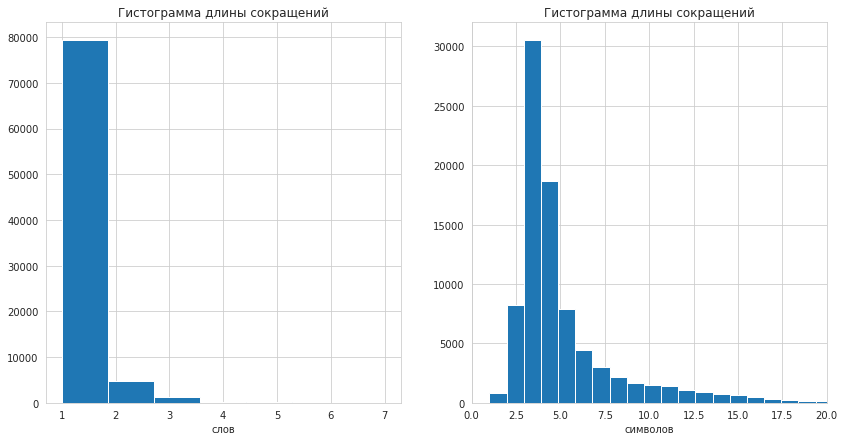

In [24]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
abbr.abbr_len.hist(bins=7)
plt.title("Гистограмма длины сокращений")
plt.xlabel("слов")

plt.subplot(1, 2, 2)
abbr["abbr_norm"].str.len().hist(bins=30)
plt.xlim(0, 20)
plt.title("Гистограмма длины сокращений")
plt.xlabel("символов")
plt.show()

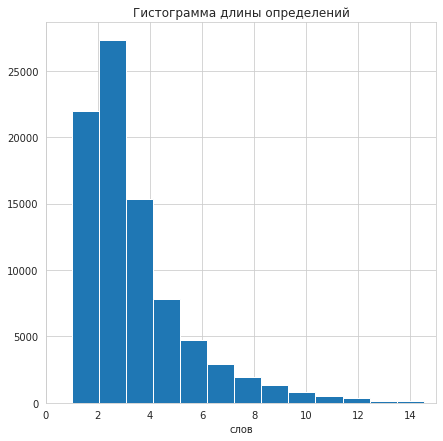

In [25]:
plt.figure(figsize=(7, 7))
abbr.desc_len.hist(bins=50)
plt.xlim(0, 15)
plt.title("Гистограмма длины определений")
plt.xlabel("слов")
plt.show()

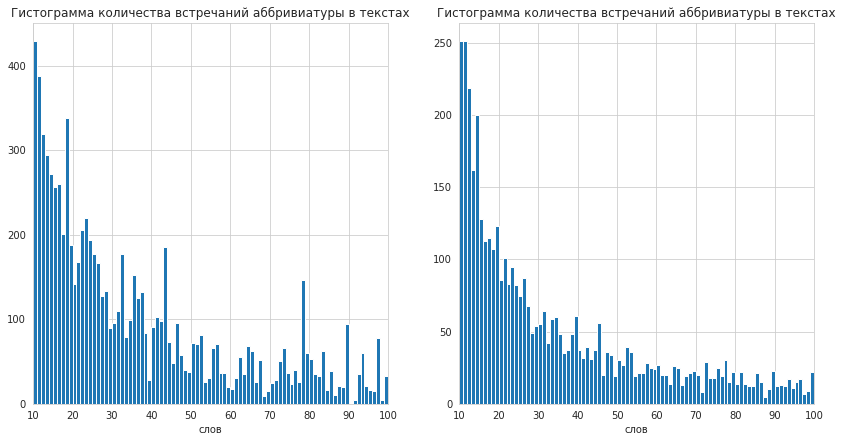

In [39]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
abbr[abbr["abbr_count"].between(10, 100)]["abbr_count"].hist(bins=90)
plt.xlim(10, 100)
plt.title("Гистограмма количества встречаний аббривиатуры в текстах")
plt.xlabel("слов")

plt.subplot(1, 2, 2)
abbr[abbr["desc_count"].between(10, 100)]["desc_count"].hist(bins=90)
plt.xlim(10, 100)
plt.title("Гистограмма количества встречаний аббривиатуры в текстах")
plt.xlabel("слов")
plt.show()

In [65]:
ABBR_LEN_MAX = 1
print("Abbr len filter", (abbr["abbr_len"] <= ABBR_LEN_MAX).sum() / abbr.shape[0])

DESC_LEN_MAX = 12
print("Desc len filter", (abbr["desc_len"] <= DESC_LEN_MAX).sum() / abbr.shape[0])

ABBR_CHAR_LEN_MIN = 2
print("Abbr char len filter", (abbr["abbr_norm"].str.len() >= ABBR_CHAR_LEN_MIN).sum() / abbr.shape[0])

from nltk.corpus import stopwords
stopwords.words("russian")
print("Stopwords filter", (~abbr["abbr_norm"].isin(stopwords.words("russian"))).sum() / abbr.shape[0])

print("Dict filter", abbr["abbr_norm"].apply(lambda x: not morph.dictionary.word_is_known(x)).sum() / abbr.shape[0])

ABBR_MIN_COUNT_IN_TEXTS = 1
print("Abbr count filter", (abbr["abbr_count"] >= ABBR_MIN_COUNT_IN_TEXTS).sum() / abbr.shape[0])

DESC_MIN_COUNT_IN_TEXTS = 20
print("Desc count filter", (abbr["desc_count"] >= DESC_MIN_COUNT_IN_TEXTS).sum() / abbr.shape[0])

abbr_filt = abbr[(abbr["abbr_len"] <= ABBR_LEN_MAX) & 
                 (abbr["desc_len"] <= DESC_LEN_MAX) &
                 (abbr["abbr_norm"].str.len() >= ABBR_CHAR_LEN_MIN) &
                 (~abbr["abbr_norm"].isin(stopwords.words("russian"))) &
                 (abbr["abbr_norm"].apply(lambda x: not morph.dictionary.word_is_known(x))) &
                 (abbr["abbr_count"] >= ABBR_MIN_COUNT_IN_TEXTS) &
                 (abbr["desc_count"] >= DESC_MIN_COUNT_IN_TEXTS)]
print("ALL filter", abbr_filt.shape[0] / abbr.shape[0])
abbr_filt

Abbr len filter 0.926825276202724
Desc len filter 0.994095984100076
Abbr char len filter 0.990506810077746
Stopwords filter 0.9899222540480505
Dict filter 0.8388729759747472
Abbr count filter 0.32071082013210966
Desc count filter 0.06669784298825042
ALL filter 0.015186765651487695


,abbr,desc,tags,desc_norm,desc_len,abbr_norm,abbr_len,abbr_count,desc_count
28,замгенпрокурора,заместитель генерального прокурора,None,заместитель генеральный прокурор,3,замгенпрокурора,1,48,65
43,РС,реактивный снаряд,None,реактивный снаряд,2,рс,1,65,33
125,СКОВС,Северо-Кавказский окружной военный суд,воен.,северо кавказский окружный военный суд,5,сковс,1,2,35
363,кл,клавиатура,"авиа, жарг., комп.",клавиатура,1,кл,1,1,135
482,ТС,«Транспортные системы»,"организация, транспорт",транспортный система,2,тс,1,32,57
...,...,...,...,...,...,...,...,...,...
85420,ЦВЕ,Центральная и Восточная Европа;,None,центральный и восточный европа,4,цве,1,2,51
85422,АК,авиационный комплекс,авиа,авиационный комплекс,2,ак,1,388,33
85457,НАО,Ненецкий автономный округ,Ненецкий АО,ненецкий автономный округ,3,нао,1,18,128
85467,инстр.,инструкция,None,инструкция,1,инстр,1,2,312


### Тексты 

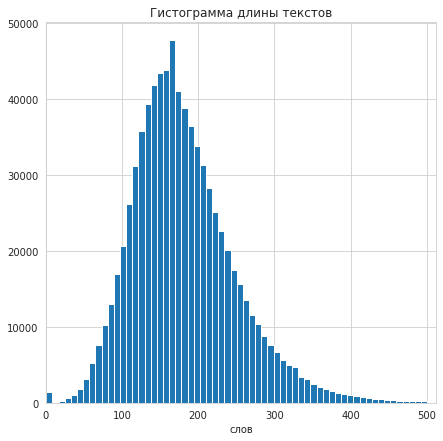

In [68]:
plt.figure(figsize=(7, 7))
lenta.text_len.hist(bins=1000)
plt.xlim(0, 512)
plt.title("Гистограмма длины текстов")
plt.xlabel("слов")
plt.show()

In [69]:
TEXT_LEN_MIN = 64
TEXT_LEN_MAX = 256

lenta_filt = lenta[lenta.text_len.between(TEXT_LEN_MIN, TEXT_LEN_MAX)]

print(lenta_filt.shape[0] / lenta.shape[0])

0.8563001342114298


## 4. Сохранение 

In [71]:
abbr_filt.drop(["tags"], axis=1, inplace=True)
abbr_filt.drop_duplicates(["desc_norm", "abbr_norm"], inplace=True)
abbr_filt["abbr_id"] = np.arange(abbr_filt.shape[0])

abbr_filt.to_csv("../data/abbr.csv", index=False, header=True)

<ipython-input-71-d2bb80bd2f05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.drop(["tags"], axis=1, inplace=True)
<ipython-input-71-d2bb80bd2f05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.drop_duplicates(["desc_norm", "abbr_norm"], inplace=True)
<ipython-input-71-d2bb80bd2f05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt["abbr_id"] = n

In [76]:
lenta_filt.drop(["url", "title", "date"], axis=1, inplace=True)

lenta_filt.to_csv("../data/lenta.csv", index=False, header=True)

<ipython-input-76-fa5b7426f9ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenta_filt.drop(["url", "title", "date"], axis=1, inplace=True)
